In [2]:
import pandas as pd
import matplotlib
import seaborn as sns
from helper_functions import load_dataset, save_dataset

### Loading the dataset

In [3]:
data = load_dataset("../data/assignment1_income_levels.xlsx")

### Inspecting the dataset

In [4]:
data.head()

,age,workclass,education,marital status,occupation,workinghours,sex,ability to speak english,gave birth this year,income
0,52,self employed,16,Widowed,Transport,50,Male,NaN,NaN,high
1,60,private,20,Divorced,Healthcare/Medical Services,30,Female,NaN,NaN,low
2,64,private,21,Divorced,Management/Business,40,Male,NaN,NaN,low
3,64,private,17,Husband,Transport,40,Male,NaN,NaN,low
4,31,private,15,Husband,Transport,40,Male,NaN,NaN,low


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       9000 non-null   int64  
 1   workclass                 9000 non-null   object 
 2   education                 9000 non-null   int64  
 3   marital status            9000 non-null   object 
 4   occupation                9000 non-null   object 
 5   workinghours              9000 non-null   int64  
 6   sex                       9000 non-null   object 
 7   ability to speak english  403 non-null    float64
 8   gave birth this year      1942 non-null   object 
 9   income                    9000 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 703.3+ KB


In [6]:
data.describe()

,age,education,workinghours,ability to speak english
count,9000.000000,9000.000000,9000.000000,403.000000
mean,43.557556,18.298778,39.227889,1.660050
std,15.280589,3.212958,12.462668,0.867355
min,17.000000,1.000000,1.000000,1.000000
25%,30.000000,16.000000,37.000000,1.000000
50%,44.000000,19.000000,40.000000,1.000000
75%,56.000000,21.000000,44.000000,2.000000
max,93.000000,24.000000,99.000000,4.000000


In [7]:
data.isnull().sum()

age                            0
workclass                      0
education                      0
marital status                 0
occupation                     0
workinghours                   0
sex                            0
ability to speak english    8597
gave birth this year        7058
income                         0
dtype: int64

In [8]:
# percentage of missing values in 'ability to speak english' column
data['ability to speak english'].isnull().sum() / len(data) * 100

95.52222222222223

In [9]:
# percentage of missing values in 'gave birth this year' column
data['gave birth this year'].isnull().sum() / len(data) * 100

78.42222222222223

### Imputing missing values & changing data types

In [10]:
# Impute missing values in 'ability to speak English' column with 0 (for native speakers)
data['ability to speak english'] = data['ability to speak english'].fillna(0)

In [11]:
# Impute missing values in 'gave birth this year' column with a 'No'
data['gave birth this year'] = data['gave birth this year'].fillna('No')

In [12]:
# change the data type of certain columns if they can be represented with smaller data types to save memory
data['age'] = data['age'].astype('int8') # in our dataset: min age is 17 and max age is 93
data['education'] = data['education'].astype('int8') # in our dataset: min education is 1 and max education is 24
data['workinghours'] = data['workinghours'].astype('int8') # in our dataset: min working hours is 1 and max working hours is 99
data['ability to speak english'] = data['ability to speak english'].astype('int8') # in our dataset: min number of 'ability to speak english' is 0 and max ability to speak english is 4

### Binning columns: 'age', 'workinghours', 'education'

In [35]:
# check how much a person has workinghours on average per age, for people older than 65, and add a second column representing the amount of people of that age
# result will be age, average workinghours, and the amount of people of that age
data['workinghours'][data['age'] > 65].groupby(data['age']).agg(['mean', 'count'])

,mean,count
age,,
66,34.346939,98
67,33.154762,84
68,33.831169,77
69,30.015625,64
70,33.440678,59
71,31.034483,58
72,25.739130,23
73,28.035714,28
74,33.424242,33


<Axes: xlabel='age', ylabel='mean'>

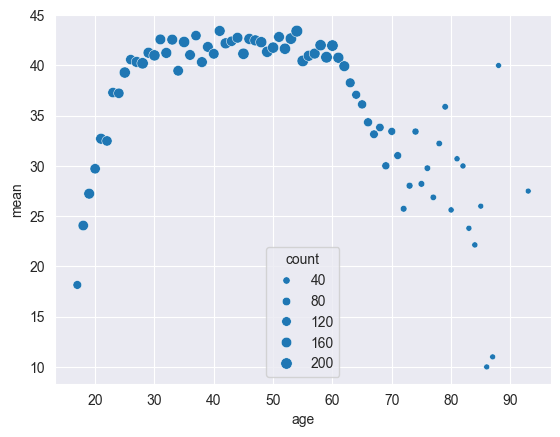

In [37]:
# plot the above with x-axis as age, y-axis as average workinghours, and the size of the point as the amount of people of that age
sns.scatterplot(data=data['workinghours'][data['age'] > 16].groupby(data['age']).agg(['mean', 'count']).reset_index(), x='age', y='mean', size='count')

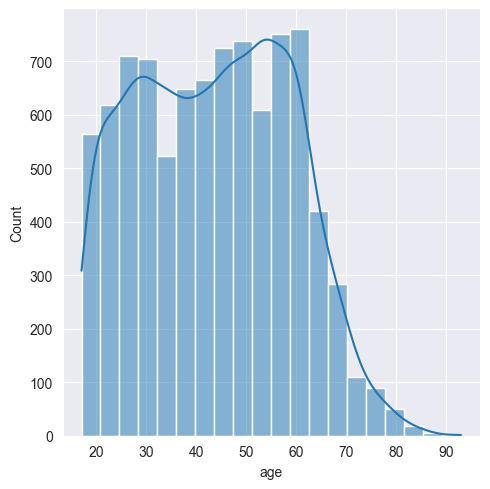

In [14]:
# plot the distribution of the 'age' column
sns.displot(data['age'], kde=True, bins=20)

In [15]:
# data['age_bin'] = pd.cut(data['age'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100'])

In [16]:
pd.qcut(data['age'], q=5, retbins=True)

(0         (49.0, 58.0]
 1         (58.0, 93.0]
 2         (58.0, 93.0]
 3         (58.0, 93.0]
 4         (28.0, 38.0]
              ...      
 8995    (16.999, 28.0]
 8996      (58.0, 93.0]
 8997      (28.0, 38.0]
 8998      (58.0, 93.0]
 8999      (49.0, 58.0]
 Name: age, Length: 9000, dtype: category
 Categories (5, interval[float64, right]): [(16.999, 28.0] < (28.0, 38.0] < (38.0, 49.0] < (49.0, 58.0] < (58.0, 93.0]],
 array([17., 28., 38., 49., 58., 93.]))

In [38]:
# data['age_bin'] = pd.qcut(data['age'], q=5, labels=['(17-28]', '(28-38]', '(38-49]', '(49-58]', '(58-93]'])
data['age_bin'] = pd.cut(data['age'], bins=[0,28,38,49,65,93], labels=['(17-28]', '(28-38]', '(38-49]', '(49-65]', '(65-93]'])

In [39]:
data['age_bin'].value_counts()

age_bin
(49-58]    2804
(38-49]    1936
(17-28]    1893
(28-38]    1710
(58-93]     657
Name: count, dtype: int64

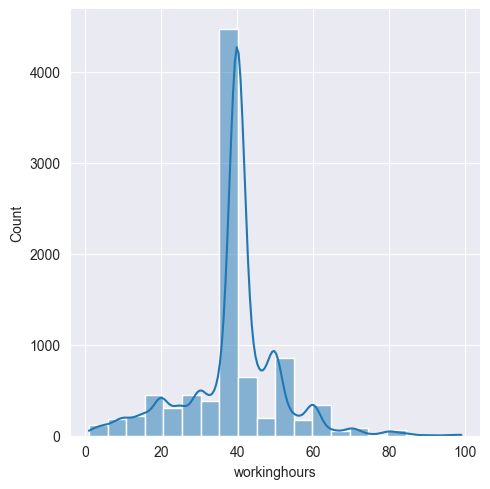

In [19]:
# plot the distribution of the 'workinghours' column
sns.displot(data['workinghours'], kde=True, bins=20)

In [20]:
# print, for bins of size 5, the frequency of each bin in ascending order on the ranges
pd.cut(data['workinghours'], bins=range(0, 105, 5)).value_counts().sort_index()

workinghours
(0, 5]        113
(5, 10]       184
(10, 15]      218
(15, 20]      452
(20, 25]      300
(25, 30]      446
(30, 35]      382
(35, 40]     4467
(40, 45]      650
(45, 50]      988
(50, 55]      199
(55, 60]      360
(60, 65]       51
(65, 70]       73
(70, 75]       28
(75, 80]       46
(80, 85]       24
(85, 90]        6
(90, 95]        1
(95, 100]      12
Name: count, dtype: int64

In [21]:
# for the ages 40 to 45, print their frequencies
data['workinghours'][(data['workinghours'] >= 40) & (data['workinghours'] <= 45)].value_counts()

workinghours
40    4190
45     461
42     102
44      38
43      38
41      11
Name: count, dtype: int64

In [22]:
# we will do customized binning for the 'workinghours' column; 'Part-time' (0-30 hours), 'Full-time' (31-40 hours), and 'Overtime' (41-99 hours)
data['workinghours_bin'] = pd.cut(data['workinghours'], bins=[0, 30, 40, 99], labels=['(0, 30]', '(30-40]', '(40-99]'])

In [23]:
data['workinghours_bin'].value_counts().sort_index()

workinghours_bin
(0, 30]    1713
(30-40]    4849
(40-99]    2438
Name: count, dtype: int64

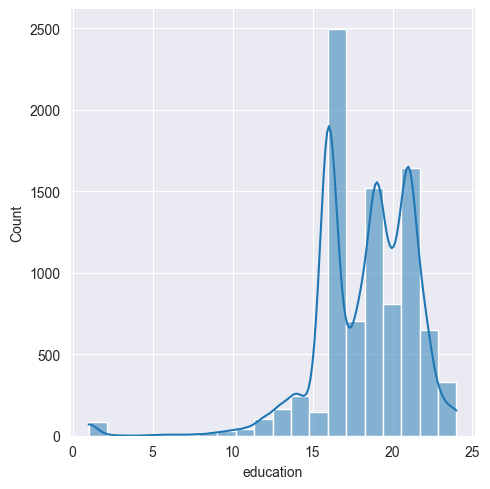

In [24]:
# plot the distribution of the 'education' column
sns.displot(data['education'], kde=True, bins=20)

In [25]:
data['education'].value_counts().sort_index()

education
1       78
2        5
3        1
5        4
6        6
7        5
8        8
9       17
10      30
11      42
12     101
13     165
14     242
15     146
16    2060
17     434
18     707
19    1523
20     807
21    1641
22     648
23     185
24     145
Name: count, dtype: int64

In [26]:
# we will do customized binning for the 'education' column; 'High School' (1-12), 'College' (13-16), and 'University' (17-24)
data['education_bin'] = pd.cut(data['education'], bins=[0, 12, 16, 24], labels=['(1-12]', '(13-16]', '(17-24]'])

In [27]:
data['education_bin'].value_counts().sort_index()

education_bin
(1-12]      297
(13-16]    2613
(17-24]    6090
Name: count, dtype: int64

In [28]:
data

,age,workclass,education,marital status,occupation,workinghours,sex,ability to speak english,gave birth this year,income,age_bin,workinghours_bin,education_bin
0,52,self employed,16,Widowed,Transport,50,Male,0,No,high,(49-58],(40-99],(13-16]
1,60,private,20,Divorced,Healthcare/Medical Services,30,Female,0,No,low,(58-93],"(0, 30]",(17-24]
2,64,private,21,Divorced,Management/Business,40,Male,0,No,low,(58-93],(30-40],(17-24]
3,64,private,17,Husband,Transport,40,Male,0,No,low,(58-93],(30-40],(17-24]
4,31,private,15,Husband,Transport,40,Male,0,No,low,(28-38],(30-40],(13-16]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,28,private,16,Never married,Education,40,Female,0,No,low,(17-28],(30-40],(13-16]
8996,61,governmental,24,Wife,Education,40,Female,0,No,high,(58-93],(30-40],(17-24]
8997,34,governmental,23,Wife,Healthcare/Medical Services,50,Female,0,No,high,(28-38],(40-99],(17-24]
8998,60,private,19,Husband,Management/Business,40,Male,0,No,low,(58-93],(30-40],(17-24]


### Writing the cleaned dataset to a new file

In [29]:
# write cleaned dataset to new file
save_dataset(data, "../data/assignment1_income_levels_cleaned.xlsx")